Train a model

In [1]:
import pickle

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn_evaluation import plot

In [2]:
upstream = ['build_features']
product = None

In [3]:
# Parameters
upstream = {
    "build_features": {
        "nb": "/Users/aiujdm2/market_watch/notebooks/build_features.ipynb",
        "data": "/Users/aiujdm2/market_watch/data/features/features.parquet",
    }
}
product = {
    "nb": "/Users/aiujdm2/market_watch/notebooks/train_model.ipynb",
    "model": "/Users/aiujdm2/market_watch/models/model.pkl",
}


In [4]:
df = pd.read_parquet(str(upstream['build_features']['data']))
X = df.drop('target', axis='columns')
y = df.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [6]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [7]:
y_pred = clf.predict(X_test)

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.94      1.00      0.97        15
           2       1.00      0.94      0.97        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

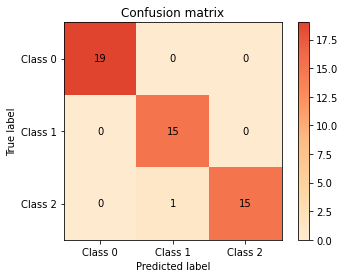

In [9]:
plot.confusion_matrix(y_test, y_pred)

In [10]:
with open(product['model'], 'wb') as f:
    pickle.dump(clf, f)